# FRboT - Food Recommender based on Time
This project aims at finding an algorithm that can find the **most probable aliment when building a meal for a specific time**. 

The problem statement is the following: 
 * The user is creating a new meal
 * The user has inserted the time of the meal
 * When it selects the "Add" button, Toto will present the $n$ aliments that are the most probable **for that specific time**

An example:<br/>
The user has selected the time 6:30 AM. <br/>
When the user clicks the "Add" button, the following aliments are going to be proposed:
 * Bacon slices
 * Eggs
 * Rugbrod boller

---
## Imports

In [1]:
import numpy as np
import requests as rq
import pandas as pd
from pandas.io.json import json_normalize
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib

sns.set_style('darkgrid')

%matplotlib inline

# Algorithm per aliment

This algorithm **only works decently** when looking at the `predict_proba` of the model. 

Looking at the `predict_proba` values works well, because it is not the **chosen/not chosen** value that I should really be interested in, but the probability that the aliment could be chosen based on historical data, **compared to the probability of other aliments**. 

This means that the important is not the probability of a single aliment, but the probability of that aliment compared to the probabilities of the other aliments, since **I want to propose the 3 most probable aliments**. 

Examples for which this is easy to visualize are those aliments that that I'm **not eating consistently every day**, which means that the **synthetic data** that I create is going to be filling also probable hours. 

### One model per Aliment

The algorithm will generate **one model per aliment** and they will all be **saved** with a specific pickle file, named with the **id of the aliment** (hash code).

In [107]:
# Let's choose the aliment for which to train the algorithm
# aliment = '5b39a79d6e167d0006a8168b' # Bacon (vores i skiver)
# aliment = 'Bread Kohberg Rugbrød boller (1)' # WORKS WELL AFTER ADDING THE NEG EX ONLY AFTER ELEMENT APPEARS IN DATASET
aliment = '5ad388741f0bb90007b41bff' # Eggs Fotex - WORKS WELL
# aliment = 'Vores Kylling Brystfilet' # WORKS WELL
# aliment = 'Rice Fuldkornris ris-fix
# aliment = 'Urtekram Fusilli Wholegrain'
# aliment = 'Broccoli (100gr)' 
# aliment = 'Cheasy mild skiveost 13%'
# aliment = '5dfcb6f91cb33a00061eb167' (this aliment should be excluded (Farro) since there is not enough data)

today = pd.Timestamp(2019, 12, 22)

---
## Data Preparation & Feature Engineering
To convert the data from a json object to a Pandas Data Frame I followed the tutorial here:
https://hackersandslackers.com/json-into-pandas-dataframes/ as well as the examples of the documentation.

A few rules: 
 * We are **excluding** aliments that have been **chosen less than $n_c$ times in the training dataset**
 * We are **engineering $2*n_pos$ positive examples** for each aliment. The positive examples are created in the time frame with the highest distribution of data for each aliment. The positive examples are **only generated in the last $d_d$ days** (for example in the last 30 days) so that we reinforce the aliments that have been chosen recently. 
 * We are **engineering $n_n$ negative examples** for each aliment. 

In [108]:
nc = 20
npos = 10
dd = 30

In [109]:
def save_aliments(distinct_aliments_ids): 
    distinct_aliments_ids.to_csv('aliments.csv')


In [110]:
def prepare_generic_data(): 
    with open('meals.json') as json_file:
        data = json.load(json_file)
        
    with open('foods.json') as json_file:
        foods_data = json.load(json_file)

    # Create the foods data and save it
    foods = json_normalize(foods_data['foods'])

    save_aliments(foods[['id', 'name']])

    # Create the data
    aliments_full = json_normalize(data['meals'], 'aliments', ['date', 'time'])

    # Drop useless columns
    aliments_full.drop(['amount', 'amountGr', 'amountMl'], axis=1, inplace=True)
    
    # Introduce hour and minutes
    #aliments_full.loc[:,'hour'] = pd.to_numeric(aliments_full['time'].str.split(':').str[0])
    #aliments_full.loc[:,'min'] = pd.to_numeric(aliments_full['time'].str.split(':').str[1])
    aliments_full.loc[:,'time'] = pd.to_numeric(aliments_full['time'].str.split(':').str[0]) + pd.to_numeric(aliments_full['time'].str.split(':').str[1]) / 60
    aliments_full.loc[:,'month'] = pd.to_datetime(aliments_full['date']).dt.month

    # Define the day of the week
    aliments_full.loc[:,'week_day'] = pd.to_datetime(aliments_full['date']).dt.weekday
    
    # Only keep the aliments that have enough data => chosen more than nc times
    aliments_chosen_enough = aliments_full['id'].value_counts()[aliments_full['id'].value_counts() > nc].index
    aliments_full = aliments_full[np.isin(aliments_full['id'], aliments_chosen_enough)]
    
    return aliments_full

aliments_full = prepare_generic_data()

In [111]:
def prepare_aliment_data(aliment_id): 

    # Only keep the chosen aliment
    aliment_data = pd.DataFrame(aliments_full[aliments_full['id'] == aliment_id])
    
    # Define meta info on day of the week
    def set_is_weekend(week_day): 
        if (week_day in [5, 6]): 
            return 1
        return 0

    # aliment_data.loc[:,'is_weekend'] = aliment_data['week_day'].apply(set_is_weekend)

    # Chosen
    aliment_data['chosen'] = 1
    
    return aliment_data

aliment_data = prepare_aliment_data(aliment)

In [112]:
def engineer_neg_examples(aliment_id, aliment_data): 
    # Synthesize negative examples
    available_aliments = aliments_full['id'].unique()

    neg_ex = pd.DataFrame()

    # Let's start adding negative examples ONLY after the aliment has started being chosen for the first time
    first_aliment_usage = aliment_data[aliment_data['chosen'] == 1]['date'].astype(int).min()

    # Iterate over all days
    for dt in aliments_full[aliments_full['date'].astype(int) >= first_aliment_usage]['date'].unique(): 

        # Get the rows corresponding to that specific week day
        day_aliments = pd.DataFrame(aliments_full.loc[aliments_full['date'] == dt])

        # Get the times of that dat for which the chosen aliment is NOT PRESENT
        times_aliment_not_present = day_aliments[np.invert(np.isin(day_aliments['time'], day_aliments[day_aliments['id'] == aliment_id]['time']))]['time'].unique()
        
        if len(times_aliment_not_present) == 0: 
            continue

        # Create a chosen=0 line for each of those times
        ncl_df = pd.DataFrame(times_aliment_not_present, columns=['time'])
        ncl_df.loc[:,'id'] = aliment
        ncl_df.loc[:,'name'] = aliments_full[aliments_full['id'] == aliment_id]['name'].unique()[0]
        ncl_df.loc[:,'date'] = dt
        ncl_df.loc[:,'week_day'] = pd.to_datetime(dt).weekday()
        ncl_df.loc[:,'month'] = int(dt[4:6])
        ncl_df.loc[:,'chosen'] = 0

        neg_ex = pd.concat([neg_ex, ncl_df], sort=False)

    aliment_data = pd.concat([aliment_data, neg_ex], sort=False)

    aliment_data[aliment_data['chosen'] == 0].head(1)
    
    return aliment_data

aliment_data = engineer_neg_examples(aliment, aliment_data)

In [113]:
def engineer_pos_examples(aliment_id, aliment_data, today):
    # Synthesize positive examples based on the last 30 days: 
    # THAT WILL REINFORCE THE BEHAVIOUR OF THE LAST DAYS
    # and help picking stuff that I've picked recently
    date_from = today - datetime.timedelta(days=dd)

    plus_data = pd.DataFrame()
    minus_data = pd.DataFrame()

    candidate_df = pd.DataFrame(aliment_data[(aliment_data['chosen'] == 1) & (pd.to_datetime(aliment_data['date']) > date_from)])

    for i in range(1,npos): 
        plus_data = pd.DataFrame(candidate_df)
        minus_data = pd.DataFrame(candidate_df)

        plus_data.loc[:,'time'] = candidate_df.loc[:,'time'] + 0.01 * i
        minus_data.loc[:,'time'] = candidate_df.loc[:,'time'] - 0.01 * i

        aliment_data = pd.concat([aliment_data, plus_data, minus_data])
        
    return aliment_data

aliment_data = engineer_pos_examples(aliment, aliment_data, today)

---
## Analysing the prepared data

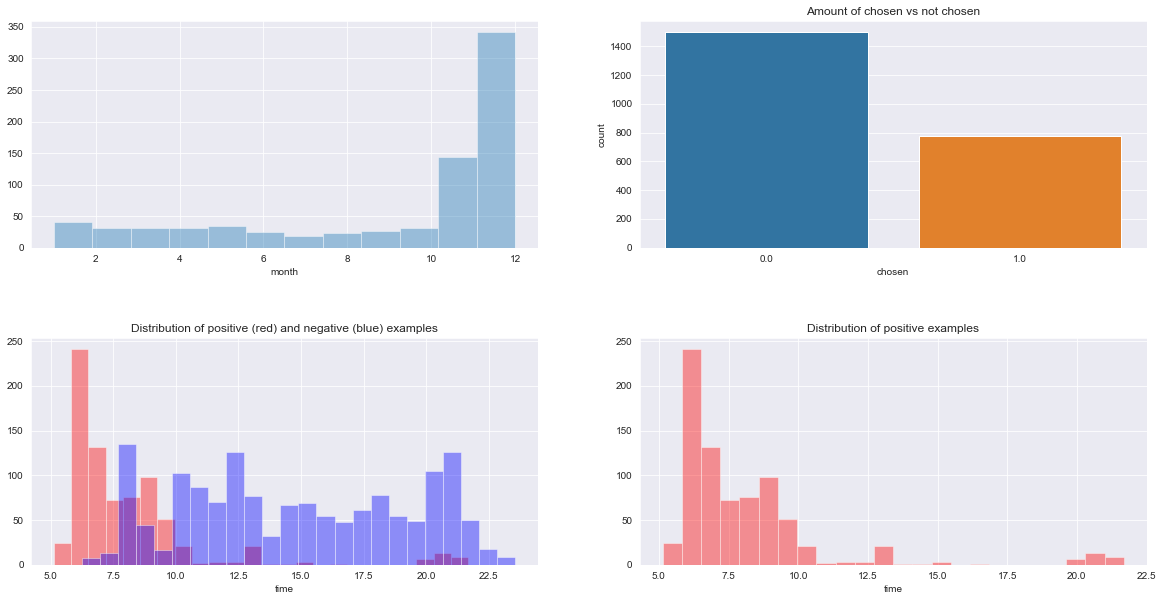

In [114]:
max_time = 24
min_time = 0

data = aliment_data[(aliment_data['time'] < max_time) & (aliment_data['time'] > min_time)]

fig, ax = plt.subplots(2,2, figsize=(20,10))
sns.distplot(aliment_data[aliment_data['chosen'] == 1]['month'].astype(int), kde=False, ax=ax[0][0], bins=12)
sns.countplot(data=data, x='chosen', ax=ax[0][1]).set_title('Amount of chosen vs not chosen')
sns.distplot(aliment_data[aliment_data['chosen'] == 1]['time'], color='red', kde=False, ax=ax[1][0], bins=24).set_title('Distribution of positive (red) and negative (blue) examples')
sns.distplot(aliment_data[aliment_data['chosen'] == 0]['time'], color='blue', kde=False, ax=ax[1][0], bins=24)
sns.distplot(aliment_data[aliment_data['chosen'] == 1]['time'], color='red', kde=False, ax=ax[1][1], bins=24).set_title('Distribution of positive examples')

plt.subplots_adjust(hspace=0.4)

The distribution of the the positive vs negative examples shows that I've created a lot of synthetic data on top of positive hours. That, of course, is due to the fact that this aliment is not consistently eaten every day, but some days yes and some others no. 

---
## Training 

NN - Training  score: 0.9479227618490346
NN - Cross Val score: 0.9438596491228071
F1 SCORE on Cross Validation set:  0.9199999999999999


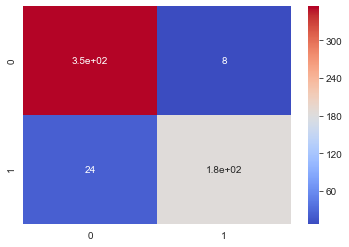

In [115]:
def train(aliment_id, aliment_data, print_results=True): 

    features_tr, features_cv = train_test_split(aliment_data, test_size=0.25)

    X = features_tr[['week_day', 'time']]
    y = features_tr['chosen']

    X_cv = features_cv[['week_day', 'time']]
    y_cv = features_cv['chosen']

    # Scaling 
    scaler = StandardScaler()
    scaler.fit(X)

    # SAVE the scaler
    joblib.dump(scaler, aliment_id + '.scaler.sav')

    X = scaler.transform(X)
    X_cv = scaler.transform(X_cv)
    
    nn_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10)).fit(X, y)
    
    if (print_results):
        print('NN - Training  score:', nn_classifier.score(X, y))
        print('NN - Cross Val score:', nn_classifier.score(X_cv, y_cv))

    y_pred = nn_classifier.predict(X_cv)

    f1 = f1_score(y_cv, y_pred)

    if (print_results):
        print('F1 SCORE on Cross Validation set: ', f1)
    
        sns.heatmap(confusion_matrix(y_cv, y_pred), cmap='coolwarm', annot=True)
    
    # Save the model
    filename = aliment_id + '.model.sav'
    pickle.dump(nn_classifier, open(filename, 'wb'))

train(aliment, aliment_data)

---
## Testing 
Test on manually engineered data

1    Egg ÆG Føtex
Name: name, dtype: object


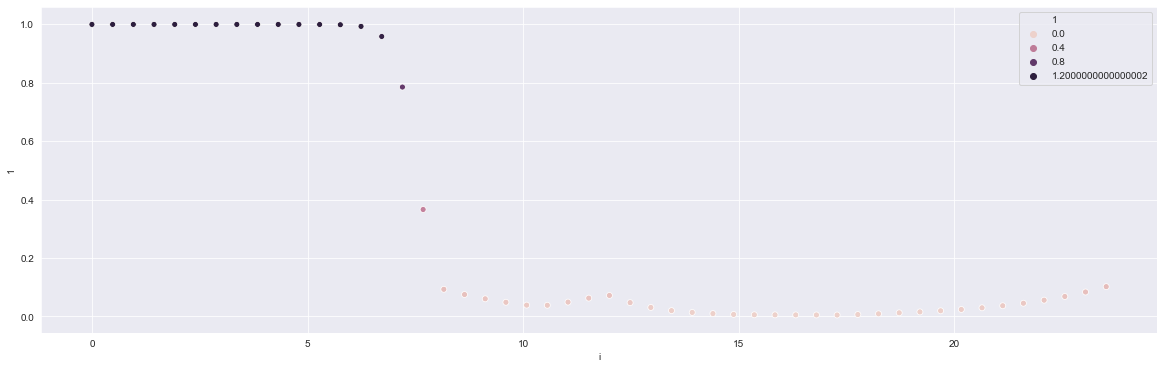

In [116]:
def test(aliment_id, print_results=True, week_day=1):

    generic_data = prepare_generic_data()
    
    aliment_name = generic_data.loc[generic_data['id'] == aliment_id, 'name'].head(1)

    test_data = pd.DataFrame(np.linspace(0, 24, 50), columns=['time'])
    test_data.loc[:,'week_day'] = week_day
    test_data.loc[:,'month'] = 12

    X_test = test_data[['week_day', 'time']]

    # Load scaler and model
    scaler = joblib.load(aliment_id + '.scaler.sav')
    loaded_model = pickle.load(open(aliment_id + ".model.sav", 'rb'))
    
    X_test = scaler.transform(X_test)

    y_pred_test = loaded_model.predict_proba(X_test)

    df = pd.DataFrame(y_pred_test, columns=['0', '1'])
    df['i'] = df.index * 24 / 50
    
    print(aliment_name)

    if (print_results):
        plt.figure(figsize=(20,6))
        sns.scatterplot(data=df, x='i', y='1', hue='1')
        
    
test(aliment)

---
---

# Full Training

This training process will generate **one model per aliment** 


In [119]:
today = pd.Timestamp(2019, 12, 22)

# Prepare the generic dataset
aliments_full = prepare_generic_data()

# Iterate per aliment
i = 1
l = len(distinct_aliments)
for aliment_id in distinct_aliments: 
    
    print("{i}/{l} - Aliment {a}: Data preparation".format(i=i, l=l, a=aliment_id))

    aliment_data = prepare_aliment_data(aliment_id)
    aliment_data = engineer_neg_examples(aliment_id, aliment_data)
    aliment_data = engineer_pos_examples(aliment_id, aliment_data, today)
    
    print("{i}/{l} - Aliment {a}: Training".format(i=i, l=l, a=aliment_id))
    
    train(aliment_id, aliment_data, print_results=False)
    
    i += 1
    
print("Done!")

1/52 - Aliment 5b39a79d6e167d0006a8168b: Data preparation
1/52 - Aliment 5b39a79d6e167d0006a8168b: Training
2/52 - Aliment 5ad388741f0bb90007b41bff: Data preparation
2/52 - Aliment 5ad388741f0bb90007b41bff: Training
3/52 - Aliment 5b2a9c156e167d0006a8162d: Data preparation
3/52 - Aliment 5b2a9c156e167d0006a8162d: Training
4/52 - Aliment 5b049b00630c7f0007fa851d: Data preparation
4/52 - Aliment 5b049b00630c7f0007fa851d: Training


/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


5/52 - Aliment 5b3527386e167d0006a8166e: Data preparation
5/52 - Aliment 5b3527386e167d0006a8166e: Training
6/52 - Aliment 5ad2237f1f0bb90007b41bee: Data preparation
6/52 - Aliment 5ad2237f1f0bb90007b41bee: Training
7/52 - Aliment 5b26c7d66e167d0006a81611: Data preparation
7/52 - Aliment 5b26c7d66e167d0006a81611: Training
8/52 - Aliment 5c052ffbbda1fa0007652e6c: Data preparation
8/52 - Aliment 5c052ffbbda1fa0007652e6c: Training
9/52 - Aliment 5b28a93b6e167d0006a8161b: Data preparation
9/52 - Aliment 5b28a93b6e167d0006a8161b: Training
10/52 - Aliment 5adced56799f2e000778fbe6: Data preparation
10/52 - Aliment 5adced56799f2e000778fbe6: Training
11/52 - Aliment 5bc711678c1add000773cce4: Data preparation
11/52 - Aliment 5bc711678c1add000773cce4: Training
12/52 - Aliment 5acdee121f0bb90007b41bc4: Data preparation
12/52 - Aliment 5acdee121f0bb90007b41bc4: Training
13/52 - Aliment 5c2cf4c022cdc00007a4bc94: Data preparation
13/52 - Aliment 5c2cf4c022cdc00007a4bc94: Training
14/52 - Aliment 5be6

/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


14/52 - Aliment 5be6da8fe6aee70008a0df7b: Training
15/52 - Aliment 5af6fec3630c7f0007fa8493: Data preparation
15/52 - Aliment 5af6fec3630c7f0007fa8493: Training
16/52 - Aliment 5b8e64d46e167d0006a81829: Data preparation
16/52 - Aliment 5b8e64d46e167d0006a81829: Training
17/52 - Aliment 5b24c37f6e167d0006a815fa: Data preparation
17/52 - Aliment 5b24c37f6e167d0006a815fa: Training
18/52 - Aliment 5b255ff36e167d0006a81602: Data preparation
18/52 - Aliment 5b255ff36e167d0006a81602: Training
19/52 - Aliment 5ad76f881f0bb90007b41c29: Data preparation
19/52 - Aliment 5ad76f881f0bb90007b41c29: Training
20/52 - Aliment 5b4f8f9b6e167d0006a8171b: Data preparation


/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


20/52 - Aliment 5b4f8f9b6e167d0006a8171b: Training
21/52 - Aliment 5b956ea27471830008bddf11: Data preparation
21/52 - Aliment 5b956ea27471830008bddf11: Training


/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


22/52 - Aliment 5b2562096e167d0006a81605: Data preparation
22/52 - Aliment 5b2562096e167d0006a81605: Training
23/52 - Aliment 5b2927986e167d0006a81621: Data preparation
23/52 - Aliment 5b2927986e167d0006a81621: Training
24/52 - Aliment 5b2948396e167d0006a81623: Data preparation
24/52 - Aliment 5b2948396e167d0006a81623: Training
25/52 - Aliment 5b376d956e167d0006a81680: Data preparation
25/52 - Aliment 5b376d956e167d0006a81680: Training
26/52 - Aliment 5aedc0fa630c7f0007fa8432: Data preparation
26/52 - Aliment 5aedc0fa630c7f0007fa8432: Training
27/52 - Aliment 5acbc2981f0bb90007b41ba6: Data preparation
27/52 - Aliment 5acbc2981f0bb90007b41ba6: Training


/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


28/52 - Aliment 5b4b7fcd6e167d0006a816fb: Data preparation
28/52 - Aliment 5b4b7fcd6e167d0006a816fb: Training
29/52 - Aliment 5b25175e6e167d0006a815fe: Data preparation
29/52 - Aliment 5b25175e6e167d0006a815fe: Training
30/52 - Aliment 5c32019922cdc00007a4bcb3: Data preparation
30/52 - Aliment 5c32019922cdc00007a4bcb3: Training
31/52 - Aliment 5bcc8890e6aee70008a0dee5: Data preparation
31/52 - Aliment 5bcc8890e6aee70008a0dee5: Training
32/52 - Aliment 5ae37d88799f2e000778fc2e: Data preparation
32/52 - Aliment 5ae37d88799f2e000778fc2e: Training
33/52 - Aliment 5ad09a4e1f0bb90007b41bde: Data preparation
33/52 - Aliment 5ad09a4e1f0bb90007b41bde: Training
34/52 - Aliment 5b263db86e167d0006a81609: Data preparation
34/52 - Aliment 5b263db86e167d0006a81609: Training
35/52 - Aliment 5b3630596e167d0006a81677: Data preparation
35/52 - Aliment 5b3630596e167d0006a81677: Training
36/52 - Aliment 5b3679796e167d0006a8167c: Data preparation
36/52 - Aliment 5b3679796e167d0006a8167c: Training
37/52 - Al

/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


45/52 - Aliment 5acbc1d81f0bb90007b41ba4: Training
46/52 - Aliment 5b392a2e6e167d0006a81688: Data preparation
46/52 - Aliment 5b392a2e6e167d0006a81688: Training


/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


47/52 - Aliment 5c6035ab22cdc00007a4bdd2: Data preparation
47/52 - Aliment 5c6035ab22cdc00007a4bdd2: Training
48/52 - Aliment 5c1fea8a22cdc00007a4bc5c: Data preparation


/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


48/52 - Aliment 5c1fea8a22cdc00007a4bc5c: Training
49/52 - Aliment 5c795b5cea3a3e0006d2160c: Data preparation
49/52 - Aliment 5c795b5cea3a3e0006d2160c: Training
50/52 - Aliment 5bbaf5fb7471830008bddfd1: Data preparation


/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


50/52 - Aliment 5bbaf5fb7471830008bddfd1: Training
51/52 - Aliment 5ade175d799f2e000778fbf3: Data preparation
51/52 - Aliment 5ade175d799f2e000778fbf3: Training
52/52 - Aliment 5d471bb5ea68390006955657: Data preparation


/Users/nicolas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


52/52 - Aliment 5d471bb5ea68390006955657: Training
Done!


### Test

107    Greek yogurt athena 2%
Name: name, dtype: object


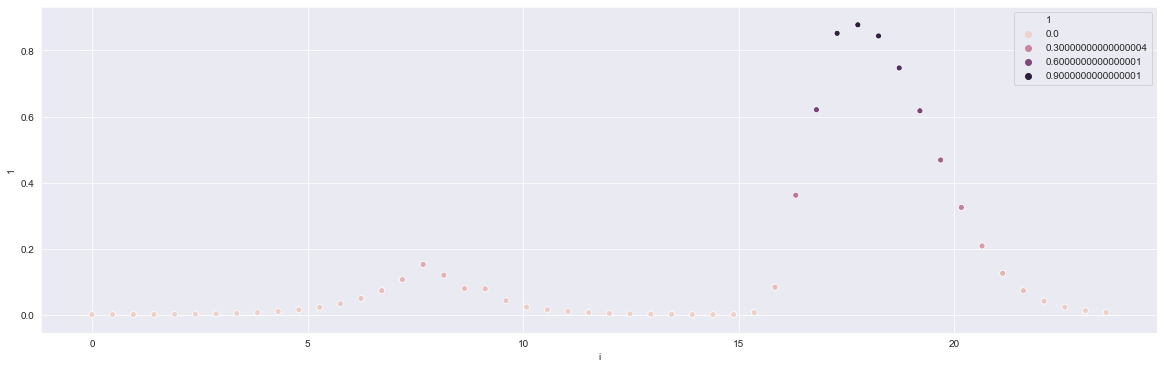

In [189]:
# test('5b49bd066e167d0006a816ee') # Bread mørke multikerne boller
# test('5b2a9c156e167d0006a8162d') # Mandorle
# test('5b049b00630c7f0007fa851d') # Beer
# test('5b3527386e167d0006a8166e') # Carots
# test('5ad2237f1f0bb90007b41bee') # Banana
# test('5b26c7d66e167d0006a81611') # Milk Vores Let Maelk
# test('5c052ffbbda1fa0007652e6c') # Puori Whey
# test('5b28a93b6e167d0006a8161b') # Bread rye generic
# test('5adced56799f2e000778fbe6') # Cheasy mild skiveost 13%
# test('5bc711678c1add000773cce4') # Olive
# test('5b39a79d6e167d0006a8168b', week_day=5) # Bacon (vores i skiver)
# test('5b39a79d6e167d0006a8168b', week_day=1) # Bacon (vores i skiver) 
test('5b25175e6e167d0006a815fe')




---
---

# Proposing most probable aliments based on time

The goal of the model was, **given a time**, to propose the $n$ most probable aliments. 

To do that we need to : 
 * Load in memory all possible aliments (only the ids)
 * Load in memory all the models
 * Give a time, run all predictions
 * Sort the highest ranking predictions
 * Pick the first $n$

In [5]:
# Load in memory the available aliments (ids)
aliments_ids = pd.read_csv('aliments.csv')

# Load in memory all the models 
models = dict()
missing_models = []
for aid in aliments_ids['id']:
    
    try: 
        # Load scaler and model
        scaler = joblib.load(aid + '.scaler.sav')
        loaded_model = pickle.load(open(aid + ".model.sav", 'rb'))

        models[aid] = [scaler, loaded_model]
    except FileNotFoundError:
        missing_models.append(aid)

if (len(missing_models) > 0): 
    print("Missing models for the following aliments: {0}".format(missing_models))

Missing models for the following aliments: ['5b97e7687471830008bddf1e', '5c71909722cdc00007a4be5a', '5b339a0d6e167d0006a81662', '5b5d970d6e167d0006a81771', '5df76e3a1cb33a00061eb148', '5b2b96b96e167d0006a81633', '5b123e05630c7f0007fa85a2', '5b26ad1a6e167d0006a8160f', '5b0a6c70630c7f0007fa8554', '5af7db56630c7f0007fa849e', '5b5c1cc96e167d0006a81765', '5d18f7c29f8a080006d661fd', '5cba2545ea3a3e0006d217dc', '5c3ceb2c22cdc00007a4bcfb', '5aecc91d630c7f0007fa8427', '5ae9771c630c7f0007fa83fe', '5c97bc94ea3a3e0006d216ec', '5b409f1f6e167d0006a816bc', '5c6c4b8e22cdc00007a4be31', '5cefe3809f8a080006d66124', '5c3997cd22cdc00007a4bce5', '5c3d592e22cdc00007a4bcfd', '5bba60797471830008bddfcf', '5ba7d9aa7471830008bddf76', '5b49bd066e167d0006a816ee', '5c719e4322cdc00007a4be5d', '5c310e5722cdc00007a4bcae', '5c1e3f6c22cdc00007a4bc57', '5ad2661a1f0bb90007b41bf2', '5b3d0e7d6e167d0006a816a7', '5ca90dc4ea3a3e0006d2176a', '5bd2206ee6aee70008a0df09', '5b3a079b6e167d0006a81690', '5c0f7fa6bda1fa0007652ea9', '5b9

In [6]:
def predict(time, week_day, n=3): 
    '''
    Predict the n most probable aliments for the specified time
    time     : a string formatted as 'hh:mm'. E.g. 06:30 or 12:32 or 23:03
    week_day : an integer representing the day of the week, ranging from 0 (Monday) to 6 (Sunday)
    n        : the number of aliments to be returned (default 3)
    '''
    # Parse the time
    hour = int(time.split(':')[0])
    minute = int(time.split(':')[1])
    
    t = hour + (minute/60)
    
    features = np.array([[week_day, t]])
    
    predictions = pd.DataFrame()
    
    # Run all predictions for that time
    for aid in aliments_ids['id']:
        
        try:
            scaler = models[aid][0]
            model = models[aid][1]

            X = scaler.transform(features)

            y_pred = model.predict_proba(X)

            predicted = pd.DataFrame(np.array([[float(y_pred[0][1])]]), columns=['proba'], dtype=float)
            predicted['aliment_id'] = aid

            predictions = pd.concat([predictions, predicted], sort=False, ignore_index=True)

        except KeyError:
            pass
        
    
    # Extract the n highest proba
    highest_ranking = predictions.sort_values(by='proba', ascending=False).head(n)
    
    return highest_ranking

def predict_aliment(aid, time, week_day): 
    '''
    Predict the "chosen" probability of the given aliment
    aid      : aliment_id
    time     : a string formatted as 'hh:mm'. E.g. 06:30 or 12:32 or 23:03
    week_day : an integer representing the day of the week, ranging from 0 (Monday) to 6 (Sunday)
    '''
    # Parse the time
    hour = int(time.split(':')[0])
    minute = int(time.split(':')[1])
    
    t = hour + (minute/60)
    
    X = np.array([[week_day, t]])
    
    predictions = pd.DataFrame()
    
    scaler = models[aid][0]
    model = models[aid][1]

    X = scaler.transform(X)

    y_pred = model.predict_proba(X)

    predicted = pd.DataFrame(np.array([[float(y_pred[0][1])]]), columns=['proba'], dtype=float)
    predicted['aliment_id'] = aid

    return predicted


In [16]:
df = predict("12:10", 2, n=4)
# df = predict_aliment('5b25175e6e167d0006a815fe', "06:20", 0)
pd.merge(df, aliments_ids, left_on='aliment_id', right_on="id")[['proba', 'aliment_id', 'name']]

,proba,aliment_id,name
0,0.663112,5b3527386e167d0006a8166e,Carots (100gr)
1,0.505514,5c42dbb822cdc00007a4bd1b,Bread Rugbrød Kohberg 6-Kerne
2,0.502951,5b8e64d46e167d0006a81829,Beetroot
3,0.440288,5ad76f881f0bb90007b41c29,Ørsted Roast beef
